In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Basic data preparation, modelling and analysis for binary classification (Census)

## Train a model only with a statistical performance purpose

In [2]:
import sys
sys.path.append("../")

import time
from sklearn import datasets

from classif_basic.data_preparation import train_valid_test_split, set_target_if_feature, automatic_preprocessing
from classif_basic.model import train_naive_xgb, pickle_save_model, prediction_train_valid_by_task, compute_best_fscore
from classif_basic.model_analysis import features_importances_from_pickle, augment_train_valid_set_with_results

In [3]:
# set your statistics purposes
model_task = 'classification'
stat_criteria = 'auc'

t0 = time.time()

### Prepare data

Fix precise % of population distribution (sex: Male, Female) and % of loan granted according to sex, to inspect the effects of FairDream.

In [4]:
# preparing the dataset on clients for binary classification
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True)

X = data.data
Y = (data.target == '>50K') * 1

In [5]:
dataset = X.copy()
dataset['target'] = Y
dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,0
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,1
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,0
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,0


In [6]:
# here, "treatment" is saw as being 'Male' and not 'Female'

df_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==1)]
df_no_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==0)]
df_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==1)]
df_no_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==0)]

print(df_response_if_feature.shape[0])
print(df_no_response_if_feature.shape[0])
print(df_response_if_not_feature.shape[0])
print(df_no_response_if_not_feature.shape[0])


# % of men selected by the initial data
df_response_if_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_feature.shape[0])

9918
22732
1769
14423


0.3037672281776417

In [7]:
# % of women selected by the initial data
df_response_if_not_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_not_feature.shape[0])

0.07267573230352081

In [8]:
len_dataset = 20_000

percentage_feature= 70
percentage_response_if_feature=70
percentage_response_if_not_feature=10

sexist_dataset = set_target_if_feature(
    df_response_if_feature=df_response_if_feature,
    df_no_response_if_feature=df_no_response_if_feature,
    df_response_if_not_feature=df_response_if_not_feature,
    df_no_response_if_not_feature=df_no_response_if_not_feature,
    len_dataset=len_dataset,
    percentage_feature=percentage_feature,
    percentage_response_if_feature=percentage_response_if_feature,
    percentage_response_if_not_feature=percentage_response_if_not_feature)

len_dataset: 20000
nb indivs feature with response: 9800
nb indivs feature with no response: 4200
nb indivs not_feature with response: 600
nb indivs not_feature with no response: 5400


In [9]:
X = sexist_dataset.loc[: , dataset.columns != 'target']
Y = sexist_dataset['target']

In [10]:
Y

872      1
34516    1
9791     1
41022    1
10340    1
        ..
13828    0
43335    0
22053    0
42307    0
24181    0
Name: target, Length: 20000, dtype: int64

### Bring your own model 

If you want to bring your own model, you have to set 3 features:

1. uncorrected_model_path
Save your model in uncorrected_model_path, for fairness analysis on relevant features
Ex: uncorrected_model_path = "/work/data/models/uncorrected_model.pkl"

2. X_train_valid, Y_train_valid
pd.DataFrame with your inputs and targets on train&valid set, of shape(nb_individuals,)

3. Y_pred_train_valid
np.ndarray with the predicted label (i.e. class) or value, of shape(nb_individuals,)

### Automatically train a model statistically performant

In [11]:
X_train, X_valid, X_train_valid, X_test, Y_train, Y_valid, Y_train_valid, Y_test = train_valid_test_split(
    X=X,
    Y=Y, 
    model_task=model_task)

In [12]:
Y_valid.shape

(2550,)

Training model with 105 features, on 14450 rows (valid 2550 rows, test 3000 rows) 
[0]	validation_0-auc:0.89674	validation_1-auc:0.89925
[87]	validation_0-auc:0.95672	validation_1-auc:0.94862
len(thresholds): 2096
(2550,)
Best Threshold=0.426503, with F-Score=0.891


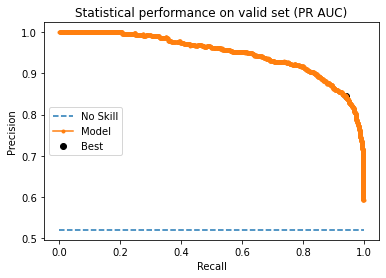

In [13]:
# save the uncorrected model, to then sort its features by importances
save_model=True
uncorrected_model_path = "/work/data/models/uncorrected_model.pkl"

Y_pred_train_valid = train_naive_xgb(
    X_train=X_train,
    X_valid=X_valid,
    X_train_valid=X_train_valid,
    X_test=X_test,
    Y_train=Y_train,
    Y_valid=Y_valid,
    Y_train_valid=Y_train_valid,
    Y_test=Y_test,
    model_task=model_task,
    stat_criteria=stat_criteria,
    save_model=save_model)

### Basic analysis of the model: DataFrame with the results, Feature Importance from Shapley values (SHAP)

In [16]:
augmented_train_valid_set = augment_train_valid_set_with_results("uncorrected", X_train_valid, Y_train_valid, Y_pred_train_valid, model_task)

We now see that this process with basic data preparation, modelling and integration of the results in a DataFrame (as storage of the model) is very fast (in seconds):

In [25]:
import numpy as np

import pickle
import shap

with open(uncorrected_model_path, "rb") as inp:
    uncorrected_model = pickle.load(inp)

explainer = shap.TreeExplainer(uncorrected_model)
#shap_values = np.array(explainer.shap_values(X_train_valid))

In [32]:
X_shap = X_train_valid.to_numpy()
Y_shap = Y_train_valid.to_numpy()

In [34]:
X_shap.reshape()

(17000, 111)

In [35]:
Y_shap.shape

(17000,)

In [33]:
import xgboost

Xd = xgboost.DMatrix(X_shap, label=Y_shap)

shap_values = explainer.shap_values(Xd)

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [17]:
features_importances_from_pickle(
    augmented_train_valid_set=augmented_train_valid_set,
    X_train_valid=X_train_valid,
    model_task=model_task,
    uncorrected_model_path=uncorrected_model_path)

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [15]:
t1 = time.time()

print(f"Basic modelling took {round(t1 - t0)} seconds")

Basic modelling took 5 seconds


The further steps are for fairness assessment and correction of the model, functionality which is available with the package FairDream of DreamQuark (private for the moment)...

## Detection alert (on train&valid data to examine if the model learned discriminant behavior)

## Discrimination correction with a new fair model

### Generating fairer models with grid search or weights distorsion

### Evaluating the best fair model